<a href="https://colab.research.google.com/github/olympus999/e-ariregistri_avaandmed/blob/main/Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main


Raw data tables:

* generic_data - General data about each company
* simple_data - Less data than general data, simplified
* paid_taxes - Taxes paid by each company per quarter

Custom tables:
* emtak_codes_text - contains all the unique emtak_codes and names with count
* company_emtak - Shows quarterly changes per company.

## Download, import and install libraries

In [1]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
# !tar xf spark-3.5.0-bin-hadoop3.tgz
# !pip install -q findspark
# !pip install ijson
# !curl -L -o "/content/spark-3.5.0-bin-hadoop3/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
# # !curl -L -o "/content/spark-3.5.0-bin-hadoop3/jars/graphframes-0.8.3-spark3.5-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.12/graphframes-0.8.3-spark3.5-s_2.12.jar
# !pip install graphframes

In [2]:
!pip install pyspark
!pip install graphframes
!pip install ijson

!curl -L -o "/usr/local/lib/python3.6/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6ea7bcce17eadb5b60e34f5157e49f3cf326dbd2263a56aebe8d79f6381f9f7c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 2.3 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0   1202      0 --:--:-- --:--:-- --:--:--  1205
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file 
100   146  100   146    0     0    515      0 --:--:-- --:--:-- --:-

In [3]:
import os
import urllib.request
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
# import findspark
# findspark.init()
import pyspark
from graphframes import GraphFrame
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql.types import *
from pyspark.sql.functions import col, regexp_replace, lit, when
from os.path import isfile
import zipfile
import json
import ast
import time
import ijson
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Setup Spark and define files

In [4]:
# conf = SparkConf().set("spark.driver.memory", "10g")\
#                   .set("spark.executor.memory", "10g")\
#                   .set("spark.jars.packages", "graphframes:graphframes-0.8.2-spark3.2-s_2.12")
spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12").config("spark.driver.memory", "10g").config("spark.executor.memory", "10g").getOrCreate()
# spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes-0.8.2-spark3.2-s_2.12").getOrCreate()
# spark = SparkSession.builder\
#                     .master("local[*]")\
#                     .config("spark.jars.packages", "graphframes:graphframes-0.8.2-spark3.2-s_2.12")\
#                     .getOrCreate()
# conf = SparkConf().set("spark.driver.memory", "10g")\
#                   .set("spark.executor.memory", "10g")\
#                   .set("spark.jars.packages", "graphframes:graphframes-0.8.2-spark3.2-s_2.12")
# spark = SparkSession.builder\
#           .config(conf=conf)\
#           .master("local[*]")\
#           .appName('avaandmed_ariregister')\
#           .getOrCreate()
# spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

In [6]:
# spark.sparkContext.getConf().getAll()

In [7]:
folder_data = 'data'
folder_data_unpacked = os.path.join(folder_data, 'unpacked')
folder_data_spark_json = os.path.join(folder_data_unpacked, 'spark_json')

# Data is downloaded from here: https://avaandmed.ariregister.rik.ee/et/avaandmete-allalaadimine#ettepanekud-ja-tagasiside
generic_data = {
    'simple_data':            'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__lihtandmed.csv.zip',
    'generic_data':           'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__yldandmed.json.zip', # Huge file
    # 'registrikaardid':        'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__registrikaardid.json.zip',
    # 'kaardile_kantud_isikud': 'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__kaardile_kantud_isikud.json.zip',
    # 'kandevalised_isikud':    'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__kandevalised_isikud.json.zip',
    # 'osanikud':               'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__osanikud.json.zip',
    # 'kasusaajad':             'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__kasusaajad.json.zip',
    # 'kommertspandiandmed':    'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__kommertspandid.json.zip',
    # 'maarused':               'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__maarused.json.zip'
}

yearly_data = {
    # 'aruannete_yldandmed':                  'https://avaandmed.ariregister.rik.ee/sites/default/files/1.aruannete_yldandmed_kuni_31102023.zip',
    # 'emtak_sales_distribution':             'https://avaandmed.ariregister.rik.ee/sites/default/files/2.EMTAK_myygitulu_kuni_31102023.zip',
    # 'myygitulu_geograafiline_jaotus':       'https://avaandmed.ariregister.rik.ee/sites/default/files/3.myygitulu_geograafiline_kuni_31102023.zip',
    # 'pohinaitajad_2020_aasta_aruannetest':  'https://avaandmed.ariregister.rik.ee/sites/default/files/4.2020_aruannete_elemendid_kuni_31102023.zip',
    # 'pohinaitajad_2021_aasta_aruannetest':  'https://avaandmed.ariregister.rik.ee/sites/default/files/4.2021_aruannete_elemendid_kuni_31102023.zip',
    # 'pohinaitajad_2022_aasta_aruannetest':  'https://avaandmed.ariregister.rik.ee/sites/default/files/4.2022_aruannete_elemendid_kuni_31102023.zip',
}

# Data is downloaded to Google Drive as they only keep the last 3 years of data available on their site.
# Data is downloaded from here: https://www.emta.ee/ariklient/amet-uudised-ja-kontakt/uudised-pressiinfo-statistika/statistika-ja-avaandmed#tasutud-maksud-failid

# It does seem that EMTAK text column is incorrect here for at least some cases.
paid_taxes = {
    'paid_taxes_2020_i_quarter':    'https://drive.google.com/uc?id=1h1-hW7sTCMlOxxvz4258W403_HC5QTJV',
    'paid_taxes_2020_ii_quarter':   'https://drive.google.com/uc?id=1qDBr9U8WtSsFucuyEkJy-Hmhx2222zpY',
    'paid_taxes_2020_iii_quarter':  'https://drive.google.com/uc?id=1LFo2bueoIcedmDUdbN6YLZN0_53HWxFY',
    'paid_taxes_2020_iv_quarter':   'https://drive.google.com/uc?id=1OIU9IlYQlRtzsccOSqB6uEHLBnq4Axst',
    'paid_taxes_2021_i_quarter':    'https://drive.google.com/uc?id=15t26vju1g3wR1Bqw7QCe7VFSIUXpgAWu',
    'paid_taxes_2021_ii_quarter':   'https://drive.google.com/uc?id=1Rz6KmBzw61T98noX4_aRWiZEiAjGUSa3',
    'paid_taxes_2021_iii_quarter':  'https://drive.google.com/uc?id=1aOJ_-KQDCs-oIFZMLqJql4IkICo5P-lk',
    'paid_taxes_2021_iv_quarter':   'https://drive.google.com/uc?id=10XyphD7LCub2B9EySdLG47KXhrJr9ipD',
    'paid_taxes_2022_i_quarter':    'https://drive.google.com/uc?id=1sU5wguPYaY2odNMM8aQRwopwm-sjL1oa',
    'paid_taxes_2022_ii_quarter':   'https://drive.google.com/uc?id=1diLKS7NhlLZg2e-c_wRYPLTTUAeTdJxP',
    'paid_taxes_2022_iii_quarter':  'https://drive.google.com/uc?id=1j0aeqXmzG3gdmcJkAZOvC_T_TfXnjNhA',
    'paid_taxes_2022_iv_quarter':   'https://drive.google.com/uc?id=1TGiL1zc_WPSTai8DrbxXSLaoVWXg11Qm',
    'paid_taxes_2023_i_quarter':    'https://drive.google.com/uc?id=1gsCyYuKYjN-nP-NdYWCYuMQZXRU8hpV6',
    'paid_taxes_2023_ii_quarter':   'https://drive.google.com/uc?id=1sskcbN0cAIaD8H4_34AyRxv2AwJliF1Q',
    'paid_taxes_2023_iii_quarter':  'https://drive.google.com/uc?id=1DPVmFwe6BkjD_j_VegXMJaLoyR7z9pcu',
    'paid_taxes_2023_iv_quarter':   'https://drive.google.com/uc?id=1DQGvUZ-vet6do2o66Kbtgsz-eI6JIE8M',
}

all_data = {**generic_data, **yearly_data, **paid_taxes}

In [8]:
# Schemas for files

key_taxes = 'paid_taxes'

csv_kwargs = {
  'encoding':     'iso8859-1',
  'header':       True,
  'inferSchema':  True,
  'sep':          ';'
}

reg_code                        = "reg_code"
company_name                    = "company_name"
company_type                    = "company_type"
registered_in_the_vat_register  = "registered_in_the_vat_register"
emtak_name                      = "emtak_name"
county                          = "county"
national_taxes                  = "national_taxes"
labor_taxes_and_payments        = "labor_taxes_and_payments"
turnover                        = "turnover"
employees                       = "employees"
period                          = "period"

schemas = {
  key_taxes :
    StructType([
      StructField(reg_code,                       StringType(), nullable=True),
      StructField(company_name,                   StringType(), nullable=True),
      StructField(company_type,                   StringType(), nullable=True),
      StructField(registered_in_the_vat_register, StringType(), nullable=True),
      StructField(emtak_name,                     StringType(), nullable=True),
      StructField(county,                         StringType(), nullable=True),
      StructField(national_taxes,                 StringType(), nullable=True), # StringType -> ´float´ - changed later, after numbers are fixed
      StructField(labor_taxes_and_payments,       StringType(), nullable=True), # StringType -> ´float´ - changed later, after numbers are fixed
      StructField(turnover,                       StringType(), nullable=True), # StringType -> ´float´ - changed later, after numbers are fixed
      StructField(employees,                      IntegerType(), nullable=True),
      StructField(period,                         StringType(), nullable=True),
    ])
}

## Functions

In [11]:
def mkdir(p):
  if not os.path.isdir(p):
    os.makedirs(p)

def get_filename(url: str, key: str = None) -> str:
  if key is not None and is_key_taxes(key):
    return key + '.csv'
  return url.split('/')[-1]

def save_avaandmed(key: str, url: str, overwrite=False) -> str:
  """CSV files will be saved to folder ´unpacked´"""
  file_name = get_filename(url, key)
  if file_name.endswith('.csv'):
    file_path_name = f"{folder_data_unpacked}/{file_name}"
  else:
    file_path_name = f"{folder_data}/{file_name}"
  if overwrite or not os.path.isfile(file_path_name):
    urllib.request.urlretrieve(url, file_path_name)

  return file_path_name

def file_path_unpacked(key: str) -> str:
  url = all_data[key]
  file_name = get_filename(url, key)
  head, _sep, tail = file_name.rpartition('.zip')
  path = os.path.join(folder_data_unpacked, (head + tail))

  if not is_json_or_csv(path):
    path = path + '.csv' # ´.csv´ is missing in some cases

  return path

def file_path_spark_json(key: str) -> str:
  url = all_data[key]
  file_name = get_filename(url)
  head, _sep, tail = file_name.rpartition('.zip')

  return os.path.join(folder_data_spark_json, (head + tail))

def create_dirs():
  mkdir(folder_data)
  mkdir(folder_data_unpacked)
  mkdir(folder_data_spark_json)

def download_files():
  for key, value in all_data.items():
    print('downloaded', key, '-', save_avaandmed(key, value))

def unpack_files():
  for f in os.listdir(folder_data):
    p = os.path.join(folder_data, f)
    if not os.path.isdir(p):
      with zipfile.ZipFile(p, "r") as zip_ref:
        zip_ref.extractall(folder_data_unpacked)
        print('unpacked', '-', p, 'to', folder_data_unpacked)

def fix_tax_numbers(df):
  def re_space(column_name: str):
    return regexp_replace(col(column_name), ' ', '')

  def re_comma(column_name: str):
    return regexp_replace(col(column_name), ',', '.')

  df = df.withColumn(national_taxes, re_space(national_taxes))\
          .withColumn(national_taxes, re_comma(national_taxes))\
          .withColumn(national_taxes, col(national_taxes).cast('float'))\
          .withColumn(labor_taxes_and_payments, re_space(labor_taxes_and_payments))\
          .withColumn(labor_taxes_and_payments, re_comma(labor_taxes_and_payments))\
          .withColumn(labor_taxes_and_payments, col(labor_taxes_and_payments).cast('float'))\
          .withColumn(turnover, re_space(turnover))\
          .withColumn(turnover, re_comma(turnover))\
          .withColumn(turnover, col(turnover).cast('float'))

  return df

def json_to_table(path: str, key: str):
  df = spark.read.json(path)
  create_table(df, key)

def csv_to_table(path: str=None, key: str=None, df: pyspark.sql.dataframe.DataFrame=None):
  assert (path is not None and key is not None) or (df is not None and key is not None), \
    "Either ´path´ and ´key´ are not ´None´ OR ´df´ and ´key´ are not ´None´"

  if df is None:
    csv_kwargs['path'] = path
    df = spark.read.csv(**csv_kwargs)

  create_table(df, key)

def create_table(df, key):
  print(f'Trying to create table ´{key}´ - ', end="")
  # df.createOrReplaceTempView(key)
  df.write.mode("overwrite").saveAsTable(key)
  print(f'Done!')

def is_json(path: str) -> bool:
  return path.endswith('.json')

def is_csv(path: str) -> bool:
  return path.endswith('.csv')

def is_json_or_csv(path: str) -> bool:
  return is_json(path) or is_csv(path)


def is_key_taxes(key: str) -> bool:
  return key.startswith(key_taxes)

def modify_json_for_spark(path: str, path_spark: str):
  # Spark expectes certain JSON format.
  # The function changes the following:
  ## [
  ##   { [record] },
  ##   { [record] }
  ## ]
  # to
  ## { [record] }
  ## { [record] }

  if is_json(path):
    print('Starting to modify JSON ', path, end="")
    start_time = time.time()
    temp_path = 'temp.json'

    # Parsing with ijson because some files are quite big in size.
    with open(path, 'r') as f:
      with open(path_spark, 'w') as json_objects:
        for n in ijson.items(f, 'item', use_float=True):
          json_objects.write(json.dumps(n) + '\n')

    time_it_took = time.time() - start_time
    print(' - done! - Time:', round(time_it_took, 1), 'seconds')
  else:
    print('NOT JSON path:', path)

def modify_downloaded_jsons():
  for key in all_data.keys():
    path = file_path_unpacked(key)
    path_spark = file_path_spark_json(key)
    modify_json_for_spark(path, path_spark)

def create_temp_tables():
  # Separate tax files and other files
  d = all_data.copy()
  tax_files = {key: d[key] for key in d.keys() if is_key_taxes(key)}
  other_files = {key: d[key] for key in d.keys() if key not in tax_files.keys()}

  # Other files into tables
  for key in other_files.keys():
    path = file_path_unpacked(key)
    if path.endswith('.json'):
      path = file_path_spark_json(key)
      json_to_table(path, key)
    elif path.endswith('.csv'):
      csv_to_table(path, key)

  # Tax data we want in one table
  df = read_tax_files(tax_files)
  df = fix_tax_file_data(df)
  csv_to_table(key=key_taxes, df=df)

def read_tax_files(tax_files):
  df = spark.createDataFrame([], schemas[key_taxes])
  schema_csv_kwargs = csv_kwargs.copy()
  schema_csv_kwargs['schema'] = schemas[key_taxes]

  for key in tax_files.keys():
    schema_csv_kwargs['path'] = file_path_unpacked(key)
    period_value = key.split('_', maxsplit=2)[-1]
    t1 = spark.read.csv(**schema_csv_kwargs)\
          .withColumn(period, lit(period_value))
    df = df.union(t1)

  df = fix_tax_numbers(df)

  return df


def fix_tax_file_data(df):
  # Fix a big incorrect number with average of previous and next quarter
  df = df.withColumn(turnover,
                      when(
                          (df[reg_code] == "12473809") &
                          (df[period] == "2022_iv_quarter"),
                          908087.1)\
                      .otherwise(df['turnover'])
                    )

  return df

In [10]:
create_dirs()

download_files()

unpack_files()

modify_downloaded_jsons()

create_temp_tables()

downloaded simple_data - data/ettevotja_rekvisiidid__lihtandmed.csv.zip
downloaded generic_data - data/ettevotja_rekvisiidid__yldandmed.json.zip
downloaded paid_taxes_2020_i_quarter - data/unpacked/paid_taxes_2020_i_quarter.csv
downloaded paid_taxes_2020_ii_quarter - data/unpacked/paid_taxes_2020_ii_quarter.csv
downloaded paid_taxes_2020_iii_quarter - data/unpacked/paid_taxes_2020_iii_quarter.csv
downloaded paid_taxes_2020_iv_quarter - data/unpacked/paid_taxes_2020_iv_quarter.csv
downloaded paid_taxes_2021_i_quarter - data/unpacked/paid_taxes_2021_i_quarter.csv
downloaded paid_taxes_2021_ii_quarter - data/unpacked/paid_taxes_2021_ii_quarter.csv
downloaded paid_taxes_2021_iii_quarter - data/unpacked/paid_taxes_2021_iii_quarter.csv
downloaded paid_taxes_2021_iv_quarter - data/unpacked/paid_taxes_2021_iv_quarter.csv
downloaded paid_taxes_2022_i_quarter - data/unpacked/paid_taxes_2022_i_quarter.csv
downloaded paid_taxes_2022_ii_quarter - data/unpacked/paid_taxes_2022_ii_quarter.csv
downloa

AttributeError: 'DataFrame' object has no attribute 'saveAsTable'

In [12]:
# create_temp_tables()

Trying to create table ´simple_data´ - Done!
Trying to create table ´generic_data´ - Done!
Trying to create table ´paid_taxes´ - Done!


## Create custom TEMP tables

### EMTAK Codes

Get different EMTAK codes with labels, sorted by most common codes.
EMTA Code shows the specific field of business the company is in, one company can have multiple EMTAK Codes

In [13]:
q = \
"""
  WITH emtak_codes_only AS (
    SELECT
      ariregistri_kood,
      explode(yldandmed.teatatud_tegevusalad.emtak_kood) AS emtak_kood
    FROM generic_data
  ),
  faulty_emtaks AS (
    SELECT ariregistri_kood
    FROM emtak_codes_only
    GROUP BY ariregistri_kood, emtak_kood
    HAVING COUNT(emtak_kood) > 1
  ),
  extracted_emtak AS (
    SELECT
      explode(
        map_from_arrays(
          yldandmed.teatatud_tegevusalad.emtak_kood,
          yldandmed.teatatud_tegevusalad.emtak_tekstina))
      AS (emtak_kood, emtak_tekstina)
    FROM generic_data
    WHERE ariregistri_kood not in (SELECT ariregistri_kood FROM faulty_emtaks)
  ),
  unique_emtak AS (
    SELECT DISTINCT emtak_kood, emtak_tekstina, count(*) as count
    FROM extracted_emtak
    GROUP BY emtak_kood, emtak_tekstina)
  SELECT * FROM unique_emtak ORDER BY count DESC
"""
emtak_codes_text = spark.sql(q).cache()
emtak_codes_text.show(20, truncate=False)

emtak_codes_text.createOrReplaceTempView('emtak_codes_text')

+----------+-----------------------------------------------------------------------------+-----+
|emtak_kood|emtak_tekstina                                                               |count|
+----------+-----------------------------------------------------------------------------+-----+
|68201     |Enda või renditud kinnisvara üürileandmine ja käitus                         |19364|
|70221     |Ärinõustamine jm juhtimisalane nõustamine                                    |13935|
|68321     |Hoonete ja üürimajade haldus (korteriühistud, elamuühistud, hooneühistud jms)|12577|
|41201     |Elamute ja mitteeluhoonete ehitus                                            |10700|
|62011     |Programmeerimine                                                             |9765 |
|96021     |Juuksuri- ja muu iluteenindus                                                |8924 |
|69202     |Raamatupidamine, maksualane nõustamine                                       |8762 |
|47911     |Jaemüük posti või 

###  Tabel displaying companies quarterly changes

In [ ]:
turnover_diff                   = f"{turnover}_diff"
national_taxes_diff             = f"{national_taxes}_diff"
labor_taxes_and_payments_diff   = f"{labor_taxes_and_payments}_diff"
employees_diff                  = f"{employees}_diff"

q = \
"""
  WITH emtak_codes_only AS (
    SELECT
      ariregistri_kood,
      explode(yldandmed.teatatud_tegevusalad.emtak_kood) AS emtak_kood
    FROM generic_data
  ),
  faulty_emtaks AS ( -- Very few companies have duplicated ´emtak_kood´ which causes issues
    SELECT ariregistri_kood
    FROM emtak_codes_only
    GROUP BY ariregistri_kood, emtak_kood
    HAVING COUNT(emtak_kood) > 1
  ),
  company_emtak AS (
    SELECT
      ariregistri_kood,
      nimi,
      yldandmed.teatatud_tegevusalad.emtak_kood[array_position(yldandmed.teatatud_tegevusalad.on_pohitegevusala, true) - 1] AS main_emtak,
      yldandmed.teatatud_tegevusalad.emtak_tekstina[array_position(yldandmed.teatatud_tegevusalad.on_pohitegevusala, true) - 1] AS main_emtak_text,
      TO_DATE(yldandmed.teatatud_tegevusalad.algus_kpv[array_position(yldandmed.teatatud_tegevusalad.on_pohitegevusala, true) - 1], 'd.M.y') as main_start_date
    FROM generic_data
    WHERE ariregistri_kood not in (SELECT ariregistri_kood FROM faulty_emtaks)
  ),
  joined_data AS (
    SELECT
      `paid_taxes`.`{reg_code}`,
      `company_emtak`.`nimi` AS `Company Name`,
      `company_emtak`.`main_emtak`,
      `company_emtak`.`main_emtak_text`,
      `company_emtak`.`main_start_date`,
      `paid_taxes`.`{registered_in_the_vat_register}`,
      `paid_taxes`.`{national_taxes}`,
      `paid_taxes`.`{labor_taxes_and_payments}`,
      `paid_taxes`.`{turnover}`,
      `paid_taxes`.`{employees}`,
      `paid_taxes`.`{period}`
    FROM company_emtak
    INNER JOIN paid_taxes ON `paid_taxes`.`{reg_code}` = `company_emtak`.`ariregistri_kood`
  ),
  diff_numbers AS (
    SELECT
      `{reg_code}`,
      `{period}`,
      `main_emtak`,
      `main_emtak_text`,
      `{turnover}`,
      `{turnover}`                  - LAG(`{turnover}`)                 OVER (PARTITION BY `{reg_code}` ORDER BY `{period}`) as `{turnover_diff}`,
      `{national_taxes}`,
      `{national_taxes}`            - LAG(`{national_taxes}`)           OVER (PARTITION BY `{reg_code}` ORDER BY `{period}`) as `{national_taxes_diff}`,
      `{labor_taxes_and_payments}`,
      `{labor_taxes_and_payments}`  - LAG(`{labor_taxes_and_payments}`) OVER (PARTITION BY `{reg_code}` ORDER BY `{period}`) as `{labor_taxes_and_payments_diff}`,
      `{employees}`,
      `{employees}`                 - LAG(`{employees}`)                OVER (PARTITION BY `{reg_code}` ORDER BY `{period}`) as `{employees_diff}`
    FROM joined_data
  )
  SELECT * FROM diff_numbers
""".format(
      reg_code                        = reg_code,
      registered_in_the_vat_register  = registered_in_the_vat_register,
      national_taxes                  = national_taxes,
      labor_taxes_and_payments        = labor_taxes_and_payments,
      turnover                        = turnover,
      employees                       = employees,
      period                          = period,
      turnover_diff                   = turnover_diff,
      national_taxes_diff             = national_taxes_diff,
      labor_taxes_and_payments_diff   = labor_taxes_and_payments_diff,
      employees_diff                  = employees_diff,
    )
company_emtak = spark.sql(q).cache()
company_emtak.show(20, truncate=False)
company_emtak.createOrReplaceTempView('company_emtak')

+--------+----------------+----------+---------------------------------------------------------+--------------+-------------+--------------+-------------------+------------------------+-----------------------------+---------+--------------+
|reg_code|period          |main_emtak|main_emtak_text                                          |turnover      |turnover_diff|national_taxes|national_taxes_diff|labor_taxes_and_payments|labor_taxes_and_payments_diff|employees|employees_diff|
+--------+----------------+----------+---------------------------------------------------------+--------------+-------------+--------------+-------------------+------------------------+-----------------------------+---------+--------------+
|10000018|2020_i_quarter  |45111     |Sõiduautode ja väikebusside (täismassiga alla 3,5 t) müük|NULL          |NULL         |635586.56     |NULL               |669944.0                |NULL                         |208      |NULL          |
|10000018|2020_ii_quarter |45111    

In [ ]:
def query_data(q):
  res = spark.sql(q).cache()
  df_res = res.toPandas()

  return df_res

# Analyze/extract data

### Filter companies and get details

Filter companies by EMTAK code and extract contact details.

In [ ]:
q = \
"""
  WITH selected_companies AS (
    SELECT
      ariregistri_kood as ariregistri_kood,
      yldandmed.teatatud_tegevusalad.emtak_kood as emtak_kood,
      yldandmed.teatatud_tegevusalad.emtak_tekstina as emtak_tekstina,
      yldandmed.aadressid[0].ehak_nimetus as ehak_nimetus, -- As of currently ´yldandmed.aadressid´ always contains 1 address
      yldandmed.aadressid[0].riik as riik,
      yldandmed.aadressid[0].riik_tekstina as riik_tekstina,
      array_compact(
        TRANSFORM(yldandmed.sidevahendid, elem ->
          CASE
            WHEN elem.liik_tekstina = 'Mobiiltelefon' THEN elem.sisu
            ELSE NULL
          END
      )) AS mobiiltelefon, -- In some cases there are multiple contact numbers for example.
      array_compact(
        TRANSFORM(yldandmed.sidevahendid, elem ->
          CASE
            WHEN elem.liik_tekstina = 'Elektronposti aadress' THEN elem.sisu
            ELSE NULL
          END
      )) AS email
    FROM generic_data
    WHERE array_contains(yldandmed.teatatud_tegevusalad.emtak_kood, '62011')
  )
  SELECT * FROM selected_companies
"""

filtered_companies = spark.sql(q).cache()
filtered_companies.show(20, truncate=False)

+----------------+--------------+-------------------------------------------------------------+--------------------------------------------+----+-------------+----------------+----------------------------+
|ariregistri_kood|emtak_kood    |emtak_tekstina                                               |ehak_nimetus                                |riik|riik_tekstina|mobiiltelefon   |email                       |
+----------------+--------------+-------------------------------------------------------------+--------------------------------------------+----+-------------+----------------+----------------------------+
|11728851        |[62011]       |[Programmeerimine]                                           |Kesklinna linnaosa, Tallinn, Harju maakond  |EST |Eesti        |[]              |[jeepld@gmail.com]          |
|16739552        |[62011]       |[Programmeerimine]                                           |Kesklinna linnaosa, Tallinn, Harju maakond  |EST |Eesti        |[]              |

In [ ]:
df_filtered_companies = filtered_companies.toPandas()

In [ ]:
df_filtered_companies

,ariregistri_kood,emtak_kood,emtak_tekstina,ehak_nimetus,riik,riik_tekstina,mobiiltelefon,email
0,11728851,[62011],[Programmeerimine],"Kesklinna linnaosa, Tallinn, Harju maakond",EST,Eesti,[],[jeepld@gmail.com]
1,16739552,[62011],[Programmeerimine],"Kesklinna linnaosa, Tallinn, Harju maakond",EST,Eesti,[],[info@044.ai]
2,14809610,[62011],[Programmeerimine],"Haabneeme alevik, Viimsi vald, Harju maakond",None,None,[+372 5541173],[0x00@bolshakov.ee]
3,16508930,[62011],[Programmeerimine],"Lasnamäe linnaosa, Tallinn, Harju maakond",None,None,[+372 53650088],[ou@0xff.me]
4,16634675,[62011],[Programmeerimine],"Rakvere linn, Lääne-Viru maakond",EST,Eesti,[],[alexzkhrdev@gmail.com]
...,...,...,...,...,...,...,...,...
10533,14863791,[62011],[Programmeerimine],None,TUR,Türgi,[],[yunemark@globalestonia.com]
10534,16651219,[62011],[Programmeerimine],None,UKR,Ukraina,[],[anna@yuppi.dev]
10535,16224954,[62011],[Programmeerimine],"Kesklinna linnaosa, Tallinn, Harju maakond",None,None,[],[eyyubhaciyevv@gmail.com]
10536,12110366,[62011],[Programmeerimine],"Põhja-Tallinna linnaosa, Tallinn, Harju maakond",EST,Eesti,[],[aron.seemel@gmail.com]


In [ ]:
q = "select * from emtak_codes_text"
df_res = query_data(q)

In [ ]:
df_res[:50]

,emtak_kood,emtak_tekstina,count
0,68201,Enda või renditud kinnisvara üürileandmine ja ...,19454
1,70221,Ärinõustamine jm juhtimisalane nõustamine,14749
2,68321,"Hoonete ja üürimajade haldus (korteriühistud, ...",12625
3,41201,Elamute ja mitteeluhoonete ehitus,11529
4,62011,Programmeerimine,10538
5,96021,Juuksuri- ja muu iluteenindus,9185
6,69202,"Raamatupidamine, maksualane nõustamine",8738
7,47911,Jaemüük posti või Interneti teel,7508
8,82991,Muud mujal liigitamata äritegevust abistavad t...,6319
9,49411,Kaubavedu maanteel,6221


In [ ]:
filtered_companies

DataFrame[ariregistri_kood: bigint, emtak_kood: array<string>, emtak_tekstina: array<string>, ehak_nimetus: string, riik: string, riik_tekstina: string, mobiiltelefon: array<string>, email: array<string>]

### Paid taxes

In [ ]:
sum_national_taxes = "National Taxes (in Billions €)"
sum_labor_taxes_and_payments = "Labor Taxes and Payments (in Billions €)"
sum_turnover = "Turnover (in Billions €)"
sum_employees = "Employees (in Thousands)"

q = """
  SELECT
    period,
    ROUND(SUM(`{national_taxes}`) / 1000000000, 2) AS `{sum_national_taxes}`,
    ROUND(SUM(`{labor_taxes_and_payments}`) / 1000000000, 2) AS `{sum_labor_taxes_and_payments}`,
    ROUND(SUM(`{turnover}`) / 1000000000, 2) AS `{sum_turnover}`,
    ROUND(SUM(`{employees}`) / 1000, 2) AS `{sum_employees}`
  FROM paid_taxes
  GROUP BY period
  SORT BY period
""".format(
      national_taxes=national_taxes,
      sum_national_taxes=sum_national_taxes,

      labor_taxes_and_payments=labor_taxes_and_payments,
      sum_labor_taxes_and_payments=sum_labor_taxes_and_payments,

      turnover=turnover,
      sum_turnover=sum_turnover,

      employees=employees,
      sum_employees=sum_employees
    )
res = spark.sql(q).cache()
res.show(50, truncate=False)

df_res = res.toPandas()
df_res = df_res.set_index('period')

+----------------+------------------------------+----------------------------------------+------------------------+------------------------+
|period          |National Taxes (in Billions €)|Labor Taxes and Payments (in Billions €)|Turnover (in Billions €)|Employees (in Thousands)|
+----------------+------------------------------+----------------------------------------+------------------------+------------------------+
|2020_i_quarter  |2.59                          |1.41                                    |19.56                   |693.31                  |
|2020_ii_quarter |2.38                          |1.33                                    |18.03                   |682.14                  |
|2020_iii_quarter|2.66                          |1.41                                    |19.38                   |628.01                  |
|2020_iv_quarter |2.64                          |1.4                                     |21.52                   |617.62                  |
|2021_i_quart

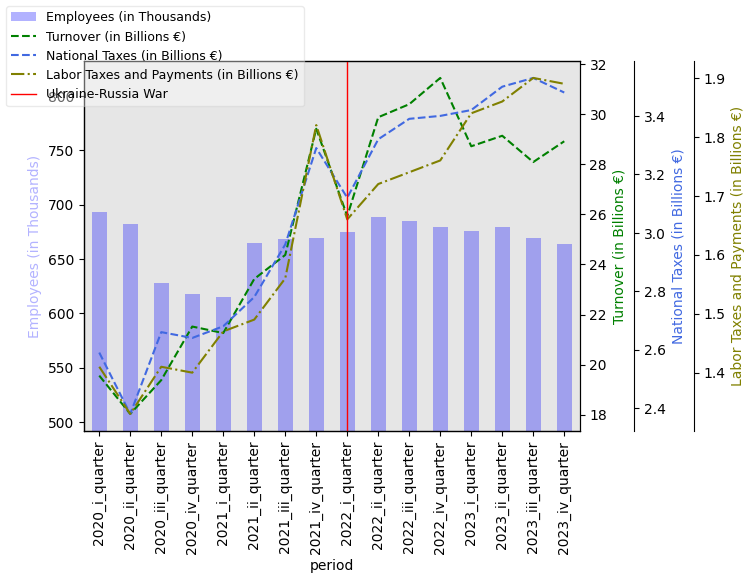

In [ ]:
kwargs = {'rot': 90}

# Employees
color = 'blue'
alpha = 0.3
ax = df_res[sum_employees].plot(kind='bar', color=color, alpha=alpha, **kwargs)
ax.set_ylabel(sum_employees, color=color, alpha=alpha)
ax.set_ylim([df_res[sum_employees].min() * 0.8, df_res[sum_employees].max()*1.2])

# Turnover
color = 'green'
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1))
df_res[sum_turnover].plot(style='--', color=color, ax=ax2, **kwargs)
ax2.set_ylabel(sum_turnover, color=color)

# National tax
color = 'royalblue'
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.11))
df_res[sum_national_taxes].plot(style='--', color=color, ax=ax2, **kwargs)
ax2.set_ylabel(sum_national_taxes, color=color)

# Labor taxes
color = 'olive'
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.23))
df_res[sum_labor_taxes_and_payments].plot(style='-.', color=color, ax=ax2, **kwargs)
ax2.set_ylabel(sum_labor_taxes_and_payments, color=color)

ax.set_facecolor((0.9, 0.9, 0.9))

plt.axvline(x=8, color='red', label='Ukraine-Russia War', linestyle='-', linewidth=1, alpha=1)

ax.figure.legend(loc=2, framealpha=0.4, fontsize=9)

There are Few interesting points on the graph. First one is the Russian invasion of Ukraine which is shown by the vertical red line. After that it is clearly visible that Turnover is significantly higher than Nation Taxes or Labor Taxes, something that did not happen in the previous 2 years the data is available. A clear indicator of inflation, especially due to energy prices - all well known by everyone.

Second interesting thing is that Labor Taxes and National Taxes are over the pre-war level peak, but Turnover has fallen below the pre-war peak and has been on a falling trend for the past few quarters. It is interesting that Turnover goes down while National Taxes go up. As previously they have been correlated and they should be correlated - probably there is a good reason. National Taxes also come from dividends - data that is not currently available for the year 2023, so that might also be the reason.

### Check how numbers for EMTAK code "62011" (name "Programmeerimine" which translates to "Programming") have changed over time

It is important to keep in mind that the selected code does not cover all IT in Estonia, it specifially covers only companies whos main field of services is Programming.

In [ ]:
sum_turnover = "Turnover (in Millions €)"
sum_change_turnover = "Turnover Change (in Millions €)"

sum_national_taxes = "National Taxes (in Millions €)"
sum_change_national_taxes = "National Taxes Change (in Millions €)"

sum_labor_taxes_and_payments = "Labor Taxes and Payments (in Millions €)"
sum_change_labor_taxes_and_payments = "Labor Taxes and Payments Change (in Millions €)"

sum_employees = "Employees"
sum_change_employees = "Employees Change"

q = \
"""
  WITH summed AS (
    SELECT
      `{period}`,
      `main_emtak`,
      `main_emtak_text`,
      ROUND(SUM(`{turnover}`) / 1000000, 2) AS `{sum_turnover}`,
      ROUND(SUM(`{national_taxes}`) / 1000000, 2) AS `{sum_national_taxes}`,
      ROUND(SUM(`{labor_taxes_and_payments}`) / 1000000, 2) AS `{sum_labor_taxes_and_payments}`,
      SUM(`{employees}`) AS `{sum_employees}`
    FROM company_emtak
    WHERE `main_emtak` = '62011'
    -- AND `{turnover_diff}` IS NOT NULL
    GROUP BY `{period}`, `main_emtak`, `main_emtak_text`
    ORDER BY `{period}`
  ),
  diffed AS (
    SELECT
      `{period}`,
      `main_emtak`,
      `main_emtak_text`,
      `{sum_turnover}`,
      `{sum_national_taxes}`,
      `{sum_labor_taxes_and_payments}`,
      `{sum_employees}`,
      ROUND(`{sum_turnover}`                  - LAG(`{sum_turnover}`)                 OVER (ORDER BY `{period}`), 2) AS `{sum_change_turnover}`,
      ROUND(`{sum_national_taxes}`            - LAG(`{sum_national_taxes}`)           OVER (ORDER BY `{period}`), 2) AS `{sum_change_national_taxes}`,
      ROUND(`{sum_labor_taxes_and_payments}`  - LAG(`{sum_labor_taxes_and_payments}`) OVER (ORDER BY `{period}`), 2) AS `{sum_change_labor_taxes_and_payments}`,
      ROUND(`{sum_employees}`                 - LAG(`{sum_employees}`)                OVER (ORDER BY `{period}`), 2) AS `{sum_change_employees}`
    FROM summed
  )
  SELECT
    `{period}`,
    `main_emtak`,
    `main_emtak_text`,
    `{sum_turnover}`,
    `{sum_change_turnover}`,
    `{sum_national_taxes}`,
    `{sum_change_national_taxes}`,
    `{sum_labor_taxes_and_payments}`,
    `{sum_change_labor_taxes_and_payments}`,
    `{sum_employees}`,
    `{sum_change_employees}`
   FROM diffed
""".format(
      national_taxes                      = national_taxes,
      labor_taxes_and_payments            = labor_taxes_and_payments,
      turnover                            = turnover,
      employees                           = employees,
      period                              = period,
      turnover_diff                       = turnover_diff,
      national_taxes_diff                 = national_taxes_diff,
      labor_taxes_and_payments_diff       = labor_taxes_and_payments_diff,
      employees_diff                      = employees_diff,
      sum_national_taxes                  = sum_national_taxes,
      sum_change_national_taxes           = sum_change_national_taxes,
      sum_labor_taxes_and_payments        = sum_labor_taxes_and_payments,
      sum_change_labor_taxes_and_payments = sum_change_labor_taxes_and_payments,
      sum_turnover                        = sum_turnover,
      sum_change_turnover                 = sum_change_turnover,
      sum_employees                       = sum_employees,
      sum_change_employees                = sum_change_employees,
    )

# res = spark.sql(q).cache()
df_programming = query_data(q).set_index(period)
# res.show(30, truncate=False)
# df_res = res.toPandas().set_index(period)

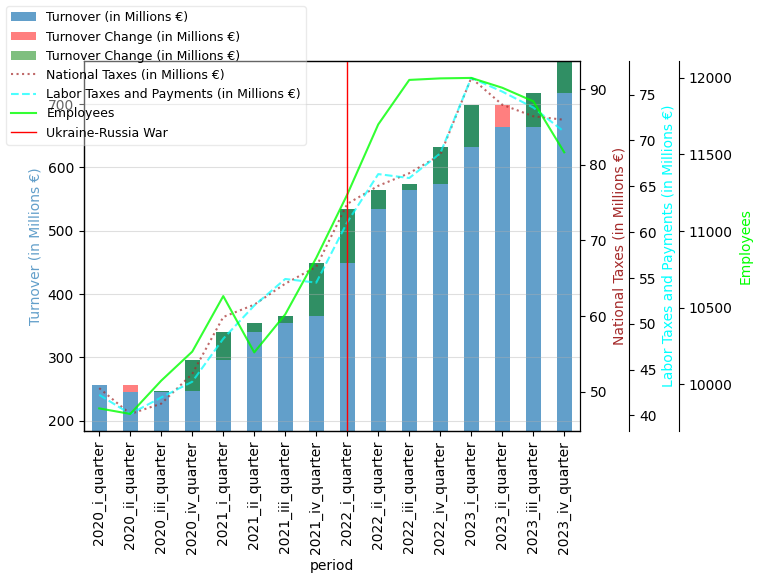

In [ ]:
kwargs = {'rot': 90}

# Turnover
ax = df_programming[[sum_turnover]].plot(kind='bar',
                                          alpha=1,
                                          legend=False,
                                          color=(0.3843137254901961, 0.6235294117647059, 0.792156862745098),
                                          **kwargs)

df_pos_change, df_neg_change = df_programming[sum_change_turnover].clip(lower=0), \
                                df_programming[sum_change_turnover].clip(upper=0)

alpha = 0.5

df_neg_change.plot(kind='bar',
                   color='red',
                   bottom=df_programming[sum_turnover] - df_neg_change,
                   ax=ax,
                   alpha=alpha,
                   **kwargs)

df_pos_change.plot(kind='bar',
                   color='green',
                   bottom=df_programming[sum_turnover] - df_pos_change,
                   ax=ax,
                   alpha=alpha,
                   **kwargs)

ax.set_ylim(bottom=df_programming[sum_turnover].min() * 0.75)
ax.set_ylabel(sum_turnover, color=(0.3843137254901961, 0.6235294117647059, 0.792156862745098), alpha=1)

# Add grid
plt.gca().yaxis.grid(True, which="major", alpha=0.4)
plt.gca().yaxis.grid(True, which="minor", alpha=0.8)

# National taxes
color = 'brown'
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1))
df_programming[sum_national_taxes].plot(style=':', color=color, ax=ax2, alpha=0.7, **kwargs)
ax2.set_ylabel(sum_national_taxes, color=color)

# Labor Taxes and Payments
color = 'aqua'
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.1))
df_programming[sum_labor_taxes_and_payments].plot(style='--', color=color, ax=ax2, alpha=0.7, **kwargs)
ax2.set_ylabel(sum_labor_taxes_and_payments, color=color)

# Employees
color = 'lime'
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.2))
df_programming[sum_employees].plot(style='-', color=color, ax=ax2, alpha=0.8, **kwargs)
ax2.set_ylabel(sum_employees, color=color)

# Ukraine war line
plt.axvline(x=8, color='red', label='Ukraine-Russia War', linestyle='-', linewidth=1, alpha=1)

# Legend
ax.figure.legend(loc=2, framealpha=0.4, fontsize=9)

# Development

### Extract e-mails

In [ ]:
q = "show tables;"
df_tables = query_data(q)

In [ ]:
for idx, row in df_tables.iterrows():
  table_name = row['tableName']
  q = """select * from {} limit 1""".format(table_name)
  df_res = query_data(q)
  print(table_name, df_res.columns)
  # print(row['tableName'])

company_emtak Index(['reg_code', 'period', 'main_emtak', 'main_emtak_text', 'turnover',
       'turnover_diff', 'national_taxes', 'national_taxes_diff',
       'labor_taxes_and_payments', 'labor_taxes_and_payments_diff',
       'employees', 'employees_diff'],
      dtype='object')
emtak_codes_text Index(['emtak_kood', 'emtak_tekstina', 'count'], dtype='object')
generic_data Index(['ariregistri_kood', 'nimi', 'yldandmed'], dtype='object')
paid_taxes Index(['reg_code', 'company_name', 'company_type',
       'registered_in_the_vat_register', 'emtak_name', 'county',
       'national_taxes', 'labor_taxes_and_payments', 'turnover', 'employees',
       'period'],
      dtype='object')
simple_data Index(['nimi', 'ariregistri_kood', 'ettevotja_oiguslik_vorm',
       'ettevotja_oigusliku_vormi_alaliik', 'kmkr_nr', 'ettevotja_staatus',
       'ettevotja_staatus_tekstina', 'ettevotja_esmakande_kpv',
       'ettevotja_aadress', 'asukoht_ettevotja_aadressis', 'asukoha_ehak_kood',
       'asukoha_eha

## Compare turnover changes among top 20 revenue fields over available data

In [ ]:
sum_turnover = "Turnover (in Millions €)"
sum_change_turnover = "Turnover Change (in Millions €)"

sum_national_taxes = "National Taxes (in Millions €)"
sum_change_national_taxes = "National Taxes Change (in Millions €)"

sum_labor_taxes_and_payments = "Labor Taxes and Payments (in Millions €)"
sum_change_labor_taxes_and_payments = "Labor Taxes and Payments Change (in Millions €)"

sum_employees = "Employees"
sum_change_employees = "Employees Change"

q = \
"""
  SELECT
    emtak_name,
    ROUND(SUM(`{turnover}`) / 1000000, 2) AS `{sum_turnover}`
  FROM paid_taxes
    GROUP BY emtak_name
""".format(
    turnover      = turnover,
    sum_turnover  = sum_turnover
)

df_res = query_data(q)
# res.show(30, truncate=False)
# df_res = res.toPandas()

In [ ]:
df_res.shape

(33, 2)

In [ ]:
t4 = query_data("""
  WITH summed AS (
    SELECT
      `{period}`,
      `main_emtak`,
      `main_emtak_text`,
      ROUND(SUM(`{turnover}`) / 1000000, 2) AS `{sum_turnover}`,
      ROUND(SUM(`{national_taxes}`) / 1000000, 2) AS `{sum_national_taxes}`,
      ROUND(SUM(`{labor_taxes_and_payments}`) / 1000000, 2) AS `{sum_labor_taxes_and_payments}`,
      SUM(`{employees}`) AS `{sum_employees}`
    FROM company_emtak
    -- WHERE `main_emtak` = '62011'
    -- AND `{turnover_diff}` IS NOT NULL
    GROUP BY `{period}`, `main_emtak_text`
    ORDER BY `{period}`
""").format(
      national_taxes                      = national_taxes,
      labor_taxes_and_payments            = labor_taxes_and_payments,
      turnover                            = turnover,
      employees                           = employees,
      period                              = period,
      turnover_diff                       = turnover_diff,
      national_taxes_diff                 = national_taxes_diff,
      labor_taxes_and_payments_diff       = labor_taxes_and_payments_diff,
      employees_diff                      = employees_diff,
      sum_national_taxes                  = sum_national_taxes,
      sum_change_national_taxes           = sum_change_national_taxes,
      sum_labor_taxes_and_payments        = sum_labor_taxes_and_payments,
      sum_change_labor_taxes_and_payments = sum_change_labor_taxes_and_payments,
      sum_turnover                        = sum_turnover,
      sum_change_turnover                 = sum_change_turnover,
      sum_employees                       = sum_employees,
      sum_change_employees                = sum_change_employees,
    )
t4

In [ ]:
t5 = query_data("""
select
  distinct(main_emtak_text, main_emtak)
from company_emtak
limit 100000;
""")
t5.columns = [str(x) for x in t5.columns]
weird_col = t5.columns[0]
t5['main_emtak_text'] = t5[weird_col].apply(lambda x: x['main_emtak_text'])
t5['main_emtak'] = t5[weird_col].apply(lambda x: x['main_emtak'])
t5 = t5.drop(columns=weird_col)

In [ ]:
t5[t5['main_emtak_text'].duplicated()]

,main_emtak_text,main_emtak
103,Elamute ja mitteeluhoonete ehitus,41201
120,Valdusfirmade tegevus,64201
130,Kaubavedu maanteel,4941
132,"Dekoratiiv- ja ehituskivi, lubjakivi, kipsi, k...",08111
141,Muu loomakasvatus,0149
...,...,...
1108,"Piimatoodete, munade, toiduõli ja -rasva hulgi...",4633
1109,Torutransport,4950
1113,"Kange alkoholi destilleerimine, rektifitseerim...",1101
1114,Hasartmängude ja kihlvedude korraldamine,9200


In [ ]:
t5[t5['main_emtak_text'] == 'Torutransport']

,main_emtak_text,main_emtak
408,Torutransport,49501
1109,Torutransport,4950


In [ ]:
t5

,"named_struct(main_emtak_text, main_emtak_text, main_emtak, main_emtak)",main_emtak_text,main_emtak
0,"(Spordirajatiste käitus, 93111)",Spordirajatiste käitus,93111
1,"(Kodulinnukasvatus, 0147)",Kodulinnukasvatus,0147
2,"(Raamatukirjastamine, 58111)",Raamatukirjastamine,58111
3,(Teatri ja tantsuetenduste lavastamine ja esit...,Teatri ja tantsuetenduste lavastamine ja esita...,90011
4,"(Taimede paljundamine, 01301)",Taimede paljundamine,01301
...,...,...,...
1112,"(Malmivalu, 24511)",Malmivalu,24511
1113,"(Kange alkoholi destilleerimine, rektifitseeri...","Kange alkoholi destilleerimine, rektifitseerim...",1101
1114,"(Hasartmängude ja kihlvedude korraldamine, 9200)",Hasartmängude ja kihlvedude korraldamine,9200
1115,"(Välissuhted, 84211)",Välissuhted,84211


In [ ]:
t5.loc[0][0]

Row(main_emtak_text='Spordirajatiste käitus', main_emtak='93111')

In [ ]:
t5.loc[0][0]['main_emtak_text']

'Spordirajatiste käitus'

In [ ]:
sum_turnover = "Turnover (in Millions €)"
sum_change_turnover = "Turnover Change (in Millions €)"

sum_national_taxes = "National Taxes (in Millions €)"
sum_change_national_taxes = "National Taxes Change (in Millions €)"

sum_labor_taxes_and_payments = "Labor Taxes and Payments (in Millions €)"
sum_change_labor_taxes_and_payments = "Labor Taxes and Payments Change (in Millions €)"

sum_employees = "Employees"
sum_change_employees = "Employees Change"

t5 = query_data("""
with grouped as (
  select
    main_emtak_text,
    count(*) as company_cnt,
    national_taxes as {sum_turnover}
  from company_emtak
  group by
    main_emtak_text, period
)
""")
t5

In [ ]:
q = \
"""
  SELECT
    DISTINCT(emtak_name)
  FROM paid_taxes
""".format(
    turnover      = turnover,
    sum_turnover  = sum_turnover
)

res = spark.sql(q).cache()
# res.show(30, truncate=False)
df_res = res.toPandas()

In [ ]:
q = \
"""
  SELECT
    *
  FROM paid_taxes
  LIMIT 1000
""".format(
    turnover      = turnover,
    sum_turnover  = sum_turnover
)

res = spark.sql(q).cache()
# res.show(30, truncate=False)
df_res = res.toPandas()

### 2023 Winners grouped by EMTAK codes

In [ ]:
df_res[sum_turnover].min() * 0.9

221.346

# Debug

In [ ]:
q = \
"""
  SELECT * FROM company_emtak
  WHERE `{turnover}` IS NULL
  AND {turnover_diff} > 0
  LIMIT 10
""".format(
    turnover        = turnover,
    turnover_diff   = turnover_diff,
)
res = spark.sql(q).cache()
res.show(20, truncate=False)

+--------+------+----------+---------------+--------+-------------+--------------+-------------------+------------------------+-----------------------------+---------+--------------+
|reg_code|period|main_emtak|main_emtak_text|turnover|turnover_diff|national_taxes|national_taxes_diff|labor_taxes_and_payments|labor_taxes_and_payments_diff|employees|employees_diff|
+--------+------+----------+---------------+--------+-------------+--------------+-------------------+------------------------+-----------------------------+---------+--------------+
+--------+------+----------+---------------+--------+-------------+--------------+-------------------+------------------------+-----------------------------+---------+--------------+



In [ ]:
# from graphframes import GraphFrame

# Define vertices and edges as DataFrames
vertices = spark.createDataFrame([(1, "Alice"), (2, "Bob"), (3, "Charlie")], ["id", "name"])
edges = spark.createDataFrame([(1, 2, "Friend"), (2, 3, "Friend")], ["src", "dst", "relationship"])

# Create a GraphFrame
graph = GraphFrame(vertices, edges)

# Show the vertices and edges of the graph
print("Vertices:")
graph.vertices.show()

print("\nEdges:")
graph.edges.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Vertices:
+---+-------+
| id|   name|
+---+-------+
|  1|  Alice|
|  2|    Bob|
|  3|Charlie|
+---+-------+


Edges:
+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  1|  2|      Friend|
|  2|  3|      Friend|
+---+---+------------+



In [ ]:
spark.stop()